In [1]:
import numpy as np
import trimesh
from tqdm import tqdm 

In [2]:
def uniform_sampling_from_mesh(vertices, faces, sample_num):
    # -------- TODO -----------
    # 1. compute area of each triangles
    # 2. compute probability of each triangles from areas
    # 3. sample N faces according to the probability
    # 4. for each face, sample 1 point
    # Note that FOR-LOOP is not allowed!
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    cross_product = np.cross(v1 - v0, v2 - v0)
    area = 0.5 * np.linalg.norm(cross_product, axis=1)

    # Compute total area
    total_area = np.sum(area)

    # Compute probability of each triangle
    prob = area / total_area

    # Sample faces according to probability
    sampled_faces = np.random.choice(len(faces), size=sample_num, p=prob)

    # Generate uniform points on sampled faces
    r1 = np.random.rand(sample_num)
    r2 = np.random.rand(sample_num)
    w1 = 1-np.sqrt(r1)
    w2 = np.sqrt(r1) * (1 - r2)
    w3 = np.sqrt(r1)*r2

    v0 = vertices[faces[sampled_faces, 0]]
    v1 = vertices[faces[sampled_faces, 1]]
    v2 = vertices[faces[sampled_faces, 2]]
    uniform_pc = w1[:, None] * v0 + w2[:, None] * v1 + w3[:, None] * v2

    # -------- TODO -----------
    return area, prob, uniform_pc
        

In [3]:
def farthest_point_sampling(pc, sample_num):
    # -------- TODO -----------
    # FOR LOOP is allowed here.
    num_points = pc.shape[0]
    
    # Initialize an array to store distances from each point to the selected set
    distances = np.full(num_points, np.inf)
    
    # Randomly select the first point as the initial sample
    first_index = np.random.randint(num_points)
    selected_indices = [first_index]
    
    # Calculate distances from the first selected point to all other points
    distances_to_first = np.linalg.norm(pc - pc[first_index], axis=1)
    distances = np.minimum(distances, distances_to_first)
    
    # Iteratively select the farthest point
    for i in tqdm(range(sample_num)):
        # Find the point with the maximum distance to the selected set
        farthest_index = np.argmax(distances)
        selected_indices.append(farthest_index)
        
        # Update distances to the newly selected point
        distances_to_new = np.linalg.norm(pc - pc[farthest_index], axis=1)
        distances = np.minimum(distances, distances_to_new)
    
    return pc[selected_indices]
    # -------- TODO -----------

In [4]:
# task 1: uniform sampling 

obj_path = 'spot.obj'
mesh = trimesh.load(obj_path)
print('faces shape: ', mesh.faces.shape)
sample_num = 512
area, prob, uniform_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, sample_num)

# Visualization. For you to check your code
np.savetxt('uniform_sampling_vis.txt', uniform_pc)

print('area shape: ',area.shape)
print('prob shape: ',prob.shape)
print('pc shape: ',uniform_pc.shape)
# the result should satisfy: 
#       area.shape = (13712, ) 
#       prob.shape = (13712, ) 
#       uniform_pc.shape = (512, 3) 

# For submission
save_dict = {'area': area, 'prob': prob, 'pc': uniform_pc}
np.save('../results/uniform_sampling_results', save_dict)

faces shape:  (13712, 3)
area shape:  (13712,)
prob shape:  (13712,)
pc shape:  (512, 3)


faces shape:  (13712, 3)

area shape:  (13712,)

prob shape:  (13712,)

pc shape:  (512, 3)

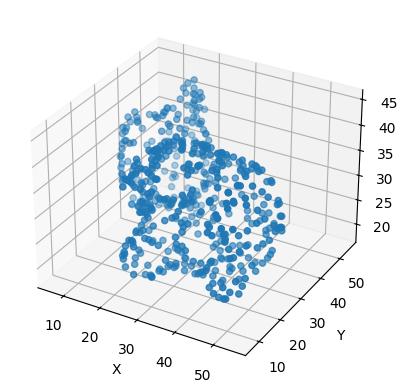

In [5]:
import matplotlib.pyplot as plt
import os

# Load your point cloud data
uniform_pc = np.loadtxt('uniform_sampling_vis.txt')

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(uniform_pc[:, 0], uniform_pc[:, 1], uniform_pc[:, 2])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Save the figure
plt.savefig(os.path.join('../results', 'uniform_sampling_results.png'))

In [6]:
# task 2: FPS

init_sample_num = 2000
final_sample_num = 512
obj_path = 'spot.obj'
mesh = trimesh.load(obj_path)
_,_, tmp_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, init_sample_num)
fps_pc = farthest_point_sampling(tmp_pc, final_sample_num)

# Visualization. For you to check your code
np.savetxt('fps_vis.txt', fps_pc)

# For submission
np.save('../results/fps_results', fps_pc)

100%|██████████| 512/512 [00:00<00:00, 30091.13it/s]


100%|██████████| 512/512 [00:14<00:00, 35.25it/s] 

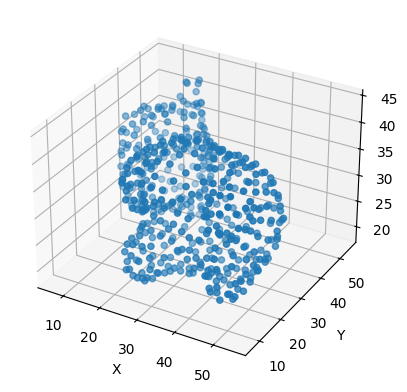

In [7]:
import matplotlib.pyplot as plt

# Load your point cloud data
fps_pc = np.loadtxt('fps_vis.txt')

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(fps_pc[:, 0], fps_pc[:, 1], fps_pc[:, 2])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Save the figure
plt.savefig(os.path.join('../results', 'fps_results.png'))

In [8]:
# task 3: metrics

from earthmover import earthmover_distance   # EMD may be very slow (1~2mins)
# -----------TODO---------------
# compute chamfer distance and EMD for two point clouds sampled by uniform sampling and FPS.
# sample and compute CD and EMD again. repeat for five times.
# save the mean and var.
CD=np.zeros((5))
EMD=np.zeros((5))

for i in range(5):
    _, _, uniform_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, sample_num)
    _,_, tmp_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, init_sample_num)
    fps_pc = farthest_point_sampling(tmp_pc, final_sample_num)
    delta=uniform_pc[None, :, :] - fps_pc[:, None, :]
    uniform_pc=[(i,j,k) for i,j,k in uniform_pc]
    fps_pc=[(i,j,k) for i,j,k in fps_pc]
    
    CD[i] = np.sum(np.min(np.linalg.norm(delta, axis=2), axis=0))/sample_num/2 + \
        np.sum(np.min(np.linalg.norm(delta, axis=2), axis=1))/final_sample_num/2
    EMD[i] = earthmover_distance(uniform_pc, fps_pc)

CD_mean = np.mean(CD)
CD_var = np.var(CD)
EMD_mean = np.mean(EMD)
EMD_var = np.var(EMD)
print('CD_mean: ', CD_mean)
print('CD_var: ', CD_var)
print('EMD_mean: ', EMD_mean)
print('EMD_var: ', EMD_var)
# -----------TODO---------------



# For submission
np.save('../results/metrics', {'CD_mean':CD_mean, 'CD_var':CD_var, 'EMD_mean':EMD_mean, 'EMD_var':EMD_var})

100%|██████████| 512/512 [00:00<00:00, 31513.44it/s]


move 0.0001218323586744674 dirt from (8.928680168506421, 41.21246200130577, 36.00224586489048) to (10.525769537197693, 44.81894139620268, 35.86942338263484) for a cost of 0.0004808139910957116
move 0.0018312926413255326 dirt from (8.928680168506421, 41.21246200130577, 36.00224586489048) to (9.966223725441129, 44.20933653742405, 31.946691509735608) for a cost of 0.009428094034342237
move 5.7108918128656594e-05 dirt from (27.37588202518317, 15.613835740349383, 20.24781128579621) to (23.6439063215302, 14.644909825785644, 21.06108641368523) for a cost of 0.00022504012857946131
move 0.0018960160818713434 dirt from (27.37588202518317, 15.613835740349383, 20.24781128579621) to (25.99674897520251, 16.142181619805793, 20.19298531790544) for a cost of 0.0028021060120487994
move 3.8072612085771063e-06 dirt from (18.78556760288633, 49.63484342815845, 42.25878941608329) to (18.395334262399704, 53.60405914398059, 37.924311287468) for a cost of 2.2425594629277447e-05
move 0.001949317738791423 dirt fr

100%|██████████| 512/512 [00:00<00:00, 32112.39it/s]


move 2.2843567251462638e-05 dirt from (28.854125044227274, 12.151327538461677, 42.075178918569236) to (28.37037942285322, 11.581742148381585, 42.15432318616901) for a cost of 1.7166164240865152e-05
move 0.0019302814327485374 dirt from (28.854125044227274, 12.151327538461677, 42.075178918569236) to (27.96675348530082, 13.968327377382519, 42.61761358727589) for a cost of 0.004041233108446654
move 0.0009746588693956837 dirt from (19.158993641183258, 49.25205732824648, 18.698121425637716) to (18.685525601709557, 49.757567257000574, 19.82949504076041) for a cost of 0.0012929277082866864
move 0.0009784661306043163 dirt from (19.158993641183258, 49.25205732824648, 18.698121425637716) to (21.35330033960583, 48.15533686948494, 20.338981426410506) for a cost of 0.0028877516504747926
move 0.0008375974658869079 dirt from (25.63108989511965, 46.112901578490785, 31.346637912688543) to (25.337862860691118, 46.470237886036145, 30.60227931726257) for a cost of 0.0007339098822616164
move 0.0011155275341

100%|██████████| 512/512 [00:00<00:00, 11526.59it/s]


move 0.001918859649122806 dirt from (6.923222722309882, 38.59396967132206, 27.80710782746573) to (6.489018049955998, 35.72044062928217, 29.06207980780771) for a cost of 0.006074231226818535
move 3.4265350877193956e-05 dirt from (6.923222722309882, 38.59396967132206, 27.80710782746573) to (7.441823597056803, 39.39941626039365, 27.68856082286669) for a cost of 3.3075284970738756e-05
move 0.0019417032163742687 dirt from (51.41489928238872, 11.443174716506213, 34.36770123327867) to (50.50299295612437, 12.001238625974072, 33.541767275603554) for a cost of 0.002623222632400432
move 1.1421783625731319e-05 dirt from (51.41489928238872, 11.443174716506213, 34.36770123327867) to (51.41736517244532, 9.815463509607406, 28.06389401201598) for a cost of 7.43622460426442e-05
move 0.001949317738791423 dirt from (21.55460782236882, 33.35034103939054, 26.329921202268125) to (21.856787288626258, 32.4271553329611, 26.55775213218905) for a cost of 0.0019449182429117676
move 3.8072612085771063e-06 dirt from

100%|██████████| 512/512 [00:00<00:00, 27234.01it/s]


move 9.518153021442766e-05 dirt from (18.34902474443879, 40.96034440953133, 22.776644650302845) to (19.65714242435324, 41.25716244085647, 23.065649728360857) for a cost of 0.0001306033755591769
move 0.0018579434697855723 dirt from (18.34902474443879, 40.96034440953133, 22.776644650302845) to (22.948767060821822, 39.82898729535858, 23.96465427189532) for a cost of 0.009073341675936661
move 0.001949317738791423 dirt from (40.06132757821124, 13.874793376272375, 36.16874388579215) to (39.93966843255048, 13.800157607388845, 36.10788875016091) for a cost of 0.0003024571934808912
move 3.8072612085771063e-06 dirt from (40.06132757821124, 13.874793376272375, 36.16874388579215) to (41.886944466242326, 13.88464078842543, 34.858622108304644) for a cost of 8.5552413048036e-06
move 1.1421783625731319e-05 dirt from (42.67834269164752, 24.116272934225645, 41.97418329804816) to (42.69468779168498, 26.321895412821423, 41.664467498201056) for a cost of 2.5439985501217746e-05
move 0.0019417032163742687 di

100%|██████████| 512/512 [00:00<00:00, 17441.07it/s]


move 0.001949317738791423 dirt from (52.316247328433526, 15.35526776072417, 24.93170987440611) to (52.4516557000604, 14.28756384737417, 26.258476272479612) for a cost of 0.0033302176133841385
move 3.8072612085771063e-06 dirt from (52.316247328433526, 15.35526776072417, 24.93170987440611) to (52.16078659108598, 18.748843098917526, 25.15996326619498) for a cost of 1.296293958560807e-05
move 0.0019455104775828458 dirt from (43.60957060015953, 25.73275637861361, 41.70850987451283) to (42.01052906228321, 28.66591779467197, 40.7569848401143) for a cost of 0.006757889535246607
move 7.6145224171542125e-06 dirt from (43.60957060015953, 25.73275637861361, 41.70850987451283) to (44.483651805132226, 30.246056331283587, 39.59853771832391) for a cost of 3.851614586302574e-05
move 0.0019455104775828458 dirt from (51.748189202364685, 17.333486355163213, 23.597594527528226) to (52.16078659108598, 18.748843098917526, 25.15996326619498) for a cost of 0.004179211639275009
move 7.6145224171542125e-06 dirt 